# 循环神经网络高级技巧
    循环dropout
        循环层用dropout降低过拟合
    堆叠循环层
        提高网络的表示能力（代价是更高的计算负荷）
    双向循环层
        信息以不同的方式呈现给循环网络，提高精度并缓解以往问题
        

In [ ]:
cd ~/Downloads
mkdir jena_climate
cd jena_climate
wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
unzip jena_climate_2009_2016.csv.zip

通用的处理以下下载到哪这里我们还是下载到自己的dataset里面

观察耶拿天气数据集的数据

In [2]:
import os

data_dir ='/home/wufisher/dataset_m/jena_climate'
fname= os.path.join(data_dir,'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))
import numpy as np


float_data = np.zeros((len(lines),len(header)-1))
for i,line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i,:]=values

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


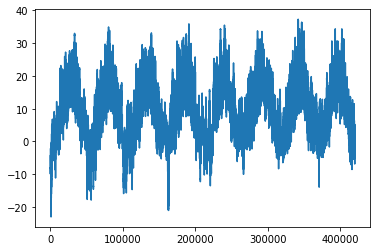

In [3]:
import numpy as np


float_data = np.zeros((len(lines),len(header)-1))
for i,line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i,:]=values

from matplotlib import pyplot as plt

temp= float_data[:,1]
plt.plot(range(len(temp)),temp)

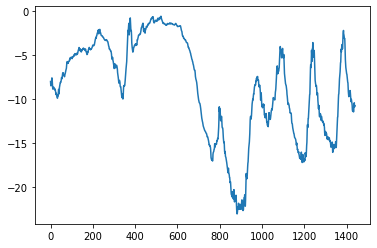

In [5]:
# 前十天
plt.plot(range(1440),temp[:1440])

准备数据
## 归一化，只标准化训练数据，并且作用在测试验证数据上

In [3]:
mean= float_data[:200000].mean(axis=0)
float_data-=mean
std =  float_data[:200000].std(axis=0)
float_data/=std

In [5]:
print(float_data)


[[ 0.90014748 -1.93135845 -1.98211036 ... -0.72950452 -0.78067973
  -0.27613603]
 [ 0.9060434  -1.97541381 -2.02567    ... -0.93124017 -0.88794488
  -0.46317443]
 [ 0.90132666 -1.98671006 -2.03683914 ... -1.27614304 -1.26122763
  -0.05330633]
 ...
 [ 1.28927851 -1.38236094 -1.46721307 ... -0.69696652 -0.67341457
   0.45008097]
 [ 1.28809932 -1.50323076 -1.58672285 ... -0.43015486 -0.60476487
   0.57246412]
 [ 1.28927851 -1.56987861 -1.65150386 ... -0.5993525  -0.690577
   0.10024989]]


生成时间序列样本迭代生成器
Lookback 过去的观测数据（相当于我的输入）
delay目标预测时间步（相当于输出点，要预测的数据 ）

## data解析 
data是二维数组，每一行为一个时间步，包含了该时间步的时间，温度等天气相关的值，进行参数输入也就是x的时候需要所有参数
但是返回结果的时候只需要data[][1]中包含的天气温度

In [4]:
def generator(data,lookback,delay,min_index,max_index,shuffle=False,batch_sice=128,step=6):
    if max_index is None:
        max_index = len(data)-delay-1
    i = min_index+lookback
    while 1 :
        if shuffle:
            rows = np.random.randint(
                min_index+lookback,max_index,size=batch_sice
            )
        else :
            if i+batch_sice>=max_index:
                i=min_index+lookback
            rows=np.arange(i,min(i+batch_sice,max_index))
            i+=len(rows)

        samples = np.zeros((len(rows),lookback//step,data.shape[-1]))
        targets = np.zeros((len(rows),))

        for j , row in enumerate(rows):
            indices = range(rows[j]-lookback,rows[j],step)
            samples[j]=data[indices]
            targets[j]=data[rows[j]+delay][1]
        yield samples , targets

In [5]:
lookback  = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
lookback=lookback,
delay=delay,
min_index=0,
max_index=200000,
shuffle=True,
step=step,
batch_sice=batch_size)

val_gen = generator(float_data,
lookback=lookback,
delay=delay,
min_index=200001,
max_index=300000,
step=step,
batch_sice=batch_size)

test_gen = generator(float_data,
lookback=lookback,
delay=delay,
min_index=300001,
max_index=None,
step=step,
batch_sice=batch_size)

# 得到验证和测试需要抽取多少次

val_steps = (300000-200001-lookback)//batch_size
test_steps = (len(float_data)-300001-lookback)//batch_size

先使用密集连接型

In [6]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import rmsprop_v2
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback//step,float_data.shape[-1])))
model.add(layers.Dense(32,activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer='rmsprop',loss='mae')
history = model.fit(
    train_gen,steps_per_epoch=500,epochs=20,validation_data=val_gen,validation_steps=val_steps
)



2021-12-20 21:07:38.909658: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-20 21:07:39.421186: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9073 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:65:00.0, compute capability: 7.5


Epoch 1/20
500/500 [==============================] - 15s 28ms/step - loss: 1.1531 - val_loss: 0.6388
Epoch 2/20
500/500 [==============================] - 13s 27ms/step - loss: 0.4023 - val_loss: 0.3126
Epoch 3/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2895 - val_loss: 0.3106
Epoch 4/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2664 - val_loss: 0.3196
Epoch 5/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2522 - val_loss: 0.3134
Epoch 6/20
500/500 [==============================] - 13s 25ms/step - loss: 0.2417 - val_loss: 0.3630
Epoch 7/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2356 - val_loss: 0.3133
Epoch 8/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2292 - val_loss: 0.3473
Epoch 9/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2231 - val_loss: 0.3253
Epoch 10/20
500/500 [==============================] - 13s 25ms/step - loss: 0.218

使用GRU型

In [7]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import rmsprop_v2
model = Sequential()
model.add(layers.GRU(32,input_shape=(None,float_data.shape[-1])))
#最后一层使用线性激活函数
model.add(layers.Dense(1))
model.compile(optimizer='rmsprop',loss='mae')
history = model.fit(
    train_gen,steps_per_epoch=500,epochs=20,validation_data=val_gen,validation_steps=val_steps
)



Epoch 1/20


2021-12-20 21:12:29.621560: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


500/500 [==============================] - 17s 29ms/step - loss: 0.3020 - val_loss: 0.2727
Epoch 2/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2843 - val_loss: 0.2677
Epoch 3/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2777 - val_loss: 0.2620
Epoch 4/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2719 - val_loss: 0.2645
Epoch 5/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2673 - val_loss: 0.2630
Epoch 6/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2624 - val_loss: 0.2643
Epoch 7/20
500/500 [==============================] - 15s 29ms/step - loss: 0.2591 - val_loss: 0.2736
Epoch 8/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2537 - val_loss: 0.2652
Epoch 9/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2514 - val_loss: 0.2753
Epoch 10/20
500/500 [==============================] - 15s 29ms/step - loss: 0.2485 - val_los

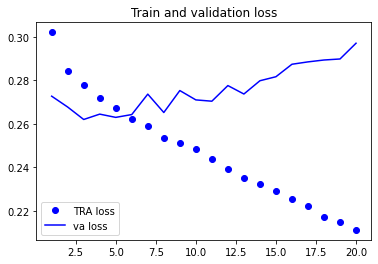

In [8]:
from matplotlib import pyplot as plt
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs = range(1,len(loss)+1)
plt.plot(epochs,loss,'bo',label='TRA loss')
plt.plot(epochs,val_loss,'b',label='va loss')
plt.title('Train and validation loss')
plt.legend()

plt.savefig('GRU_v1_loss.png')
plt.show()